In [6]:
pip install lifetimes --user

  Using cached https://files.pythonhosted.org/packages/c5/1f/ee6a471dcb5cb2f4dbc219023e07991f3b917875f9c8a5f5d77c00ddabca/Lifetimes-0.11.3-py3-none-any.whl
Note: you may need to restart the kernel to use updated packages.


In [1]:
#importing libraries
#!/usr/bin/env python2
import pandas as pd
from matplotlib import pyplot as plt 
%matplotlib inline
from lifetimes import plotting
from lifetimes import utils
from lifetimes import BetaGeoFitter
from lifetimes import GammaGammaFitter

import seaborn as sns # for plotting graphs
import datetime as dt
import numpy as np


In [2]:
#getting connected with the data
import os
import pymysql
import pandas as pd

host = os.getenv('MYSQL_HOST')
port = os.getenv('MYSQL_PORT')
user = os.getenv('MYSQL_USER')
password = os.getenv('MYSQL_PASSWORD')
database = os.getenv('MYSQL_DATABASE')

conn = pymysql.connect(
    host='20.46.45.108',
    port=int(3306),
    user="datauser",
    passwd='waslRp@098',
    db="wasldb",
    charset='utf8mb4')

In [4]:
print(conn)

In [3]:
# executing query to fetch data 
query="select USER_OID,TXN_DATE,PAID_AMOUNT,BILL_AMOUNT, OID from rp_transaction where TXN_TYPE="+"'PURCHASE'"+ "and TXN_STATUS not in ( "+"'CANCELLED','PAYMENT_FAILED')"
cursor = conn.cursor()
data=cursor.execute(query)
df = pd.DataFrame(cursor.fetchall())

In [5]:
df.head()

,0,1,2,3,4
0,3,2020-05-01 14:10:27,None,0.0000,1
1,18,2020-05-05 17:15:50,0.0000,0.0000,4
2,15,2020-05-08 10:46:50,None,0.0000,5
3,4,2020-05-11 23:26:40,0.0000,0.0000,6
4,4,2020-05-12 09:56:02,0.0000,0.0000,7


#### Data Preprocessing

In [6]:
df.replace(to_replace=[None], value=np.nan, inplace=True)

In [7]:
df.head()

,0,1,2,3,4
0,3,2020-05-01 14:10:27,NaN,0.0000,1
1,18,2020-05-05 17:15:50,0.0000,0.0000,4
2,15,2020-05-08 10:46:50,NaN,0.0000,5
3,4,2020-05-11 23:26:40,0.0000,0.0000,6
4,4,2020-05-12 09:56:02,0.0000,0.0000,7


In [8]:
df=df.fillna(0)

In [9]:
df.columns = ["USER_OID", "TXN_DATE", "PAID_AMOUNT", "BILL_AMOUNT","OID"]
df.head()

,USER_OID,TXN_DATE,PAID_AMOUNT,BILL_AMOUNT,OID
0,3,2020-05-01 14:10:27,0,0.0000,1
1,18,2020-05-05 17:15:50,0.0000,0.0000,4
2,15,2020-05-08 10:46:50,0,0.0000,5
3,4,2020-05-11 23:26:40,0.0000,0.0000,6
4,4,2020-05-12 09:56:02,0.0000,0.0000,7


In [10]:
df = df[df['PAID_AMOUNT']!=0]

In [11]:
df

,USER_OID,TXN_DATE,PAID_AMOUNT,BILL_AMOUNT,OID
12,4,2020-05-12 15:50:38,1490.0000,1490.0000,18
20,4,2020-05-12 22:19:20,1345.0000,1345.0000,32
21,4,2020-05-13 00:53:20,62.1500,62.1500,33
32,4,2020-05-13 17:07:31,685.0000,685.0000,49
92,38,2020-05-20 14:56:48,50.5000,505.0000,116
...,...,...,...,...,...
55498,3482,2020-10-14 00:02:27,262.0000,262.0000,62519
55499,3482,2020-10-14 00:02:47,139.0000,139.0000,62520
55500,3482,2020-10-14 00:03:13,328.0000,328.0000,62521
55504,6485,2020-10-14 01:35:19,463.0000,553.0000,62525


#### counting customers and transactions

In [12]:
print('Number of customers = {}'.format(df['USER_OID'].nunique()))
print('Number of transactions = {}'.format(df['TXN_DATE'].count()))

Number of customers = 2978
Number of transactions = 24247


In [13]:
df['TXN_DATE'] = pd.to_datetime(df['TXN_DATE']).dt.date
df['USER_OID'] = df['USER_OID'].astype(str)
df['PAID_AMOUNT'] = df['PAID_AMOUNT'].astype(int)

# Objective
The primary goal of this work is to build a probabilistic model for forecasting customer lifetime value in non-contractual setting on an individual level.

Using the results of this exercise, managers should be able to:

  - Distinguish active customers from inactive customers.
  - Generate transaction forecasts for individual customers.
  - Predict the purchase volume of the entire customer base.


### For all models, the following nomenclature is used:

•frequency represents the number of repeatpurchases the customer has made. It’s the count of time periods the customer had a purchase in. So if using days as units, then it’s the count of days the customer had a purchase on.

•T represents the age of the customer in whatever time units chosen (weekly, in the above dataset). This is equal to the duration between a customer’s first purchase and the end of the period under study.

•recency represents the age of the customer when they made their most recent purchases. This is equal to the duration between a customer’s first purchase and their latest purchase. (Thus if they have made only 1 purchase,the recency is 0.)

•monetary_value represents the average value of a given customer’s purchases.  This is equal to the sum of all a customer’s purchases divided by the total number of purchases. Note that the denominator here is different than the frequency described above.

## RFM DATAFRAME

For a customer these parameters are defined as :--

frequency = total number of transaction in the year - 1
recency = last tramsaction date - first transaction date
T = end of observation period - first transaction date
monetary value = mean of total amount paid by customer after first transaction

In [14]:
data = utils.summary_data_from_transaction_data(
    df,
    'USER_OID',
    'TXN_DATE',
    'PAID_AMOUNT'
)
data.head(10)

,frequency,recency,T,monetary_value
USER_OID,,,,
10,0.0,0.0,22.0,0.000000
1000,41.0,80.0,86.0,312.756098
1001,8.0,85.0,98.0,564.000000
1002,0.0,0.0,25.0,0.000000
1003,11.0,81.0,92.0,365.636364
1004,7.0,54.0,82.0,297.428571
1005,0.0,0.0,64.0,0.000000
1006,4.0,11.0,33.0,222.500000
1007,12.0,90.0,93.0,299.583333


count    2849.000000
mean        5.320463
std         7.933148
min         0.000000
25%         0.000000
50%         2.000000
75%         7.000000
max        73.000000
Name: frequency, dtype: float64
30.15093015093015% of customer transacted only once


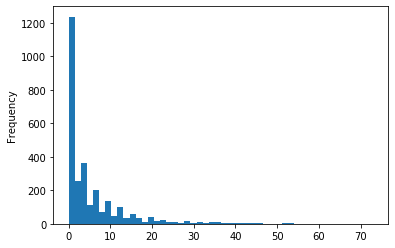

In [23]:
data['frequency'].plot(kind='hist', bins=50)
print(data['frequency'].describe())
print('{}% of customer transacted only once'.format(sum(data['frequency'] == 0) * 100 / float(len(data))))

## Model Training

### applying BetaGeoFitter

In [15]:
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(data['frequency'], data['recency'], data['T'])
print(bgf)

<lifetimes.BetaGeoFitter: fitted with 2978 subjects, a: 0.01, alpha: 8.99, b: 0.43, r: 0.88>


In [27]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.722493,0.333919,0.068012,1.376974
alpha,5.089963,3.157870,-1.099462,11.279389
a,0.001167,0.145146,-0.283319,0.285653
b,0.007696,0.956522,-1.867088,1.882480


### Visualizing our Frequency/Recency MatrixConsider:

a customer bought from you every day for three weeks straight, and we haven’t heard from them in months.What  are  the  chances  they  are  still  “alive”?   Pretty  small.   On  the  other  hand,  a  customer  who  historically  buys from you once a quarter,  and bought last quarter,  is likely still alive.   We can visualize this relationship using theFrequency/Recency matrix, which computes the expected number of transactions an artificial customer is to make in the next time period, given his or her recency (age at last purchase) and frequency (the number of repeat transactions he or she has made)

We now plot the expected number of transactions a customer with given recency and frequency will do in next 1 day.
We can see the customers at the bottom right of plot below have made a lot of repeat transactions when they quite old (yellow region).
These are the best customers who are expected to make the highest number of transactions in the next one day.

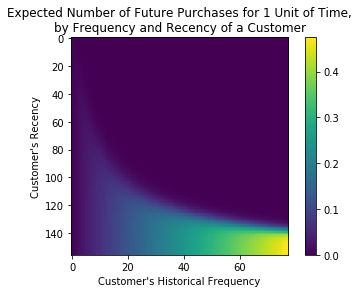

In [16]:
plotting.plot_frequency_recency_matrix(bgf)

We can see that if a customer has bought 62 times from you, and their latest purchase was when they were 147 days old (given the individual is 21 weeks old), then they are your best customer (bottom-right). 
Your coldest customers are those that are in the top-right corner: they bought a lot quickly, and we haven’t seen them in weeks.There’s also that beautiful “tail” around (5,60).  That represents the customer who buys infrequently, but we’ve seen him or her recently, so they might buy again - we’re not sure if they are dead or just between purchases

Next we plot the porbabilty of customer being alive with given recency and frequency.
We can see the customers at the bottom right of plot below have made a lot of repeat transactions when they quite old (yellow region).
These are the best customers who are surely active with us. 

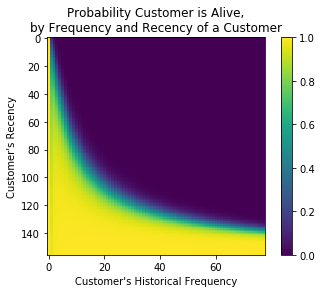

In [17]:
plotting.plot_probability_alive_matrix(bgf)

Next we get the list of our best customers who are expected to transact the most on the next day. 

In [18]:
t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
USER_OID,,,,,
712,57.0,93.0,94.0,201.315789,0.561639
6485,21.0,25.0,25.0,456.761905,0.642921
1761,67.0,90.0,92.0,154.656716,0.671455
490,77.0,103.0,104.0,74.545455,0.688896
3482,53.0,68.0,68.0,2688.509434,0.699481


 we can see that the customer with OID 3482 has 50 purchases, and bought very recently from us, is probably going to buy again in the next period.  

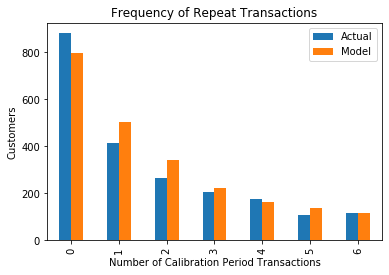

In [19]:
plotting.plot_period_transactions(bgf)

Till now we were training the model on the whole of the dataset.
Now we split the dataset into the training (caliberation) and testing (holdout) sets.
Training set is choosen till 2020-06-30.
Testing set is from 2020-07-01 to the end of available data set

In [21]:
summary_cal_holdout = utils.calibration_and_holdout_data(
    df,
    'USER_OID',
    'TXN_DATE',
    calibration_period_end='2020-07-14',
    observation_period_end='2020-07-15'
)   
print(summary_cal_holdout.head())

          frequency_cal  recency_cal  T_cal  frequency_holdout  \
USER_OID                                                         
1001                2.0          5.0    6.0                0.0   
1003                0.0          0.0    0.0                0.0   
1007                0.0          0.0    1.0                0.0   
1008                3.0          9.0    9.0                0.0   
1015                0.0          0.0    3.0                0.0   

          duration_holdout  
USER_OID                    
1001                   1.0  
1003                   1.0  
1007                   1.0  
1008                   1.0  
1015                   1.0  


Now we retrain the model on the training set and validate its performance on the test set.
We can see from the plot at the bottom that the model is performing quite well on this dataset

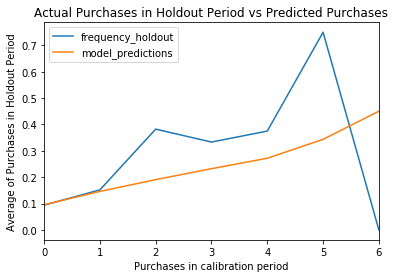

In [22]:
bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
plotting.plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

In [24]:
df

,USER_OID,TXN_DATE,PAID_AMOUNT,BILL_AMOUNT,OID
12,4,2020-05-12,1490,1490.0000,18
20,4,2020-05-12,1345,1345.0000,32
21,4,2020-05-13,62,62.1500,33
32,4,2020-05-13,685,685.0000,49
92,38,2020-05-20,50,505.0000,116
...,...,...,...,...,...
54714,3482,2020-10-12,225,225.0000,61651
54715,3482,2020-10-12,274,274.0000,61652
54716,3482,2020-10-12,300,375.0000,61653
54718,8652,2020-10-13,100,200.0000,61655


In [23]:
data

,frequency,recency,T,monetary_value,predicted_purchases
USER_OID,,,,,
10,0.0,0.0,22.0,0.000000,0.028239
1000,41.0,80.0,86.0,312.756098,0.438348
1001,8.0,85.0,98.0,564.000000,0.082438
1002,0.0,0.0,25.0,0.000000,0.025749
1003,11.0,81.0,92.0,365.636364,0.116935
...,...,...,...,...,...
992,3.0,87.0,94.0,275.000000,0.037334
993,0.0,0.0,46.0,0.000000,0.015922
994,19.0,86.0,90.0,163.210526,0.200403


In [24]:
###We are ranking customers from “highest expected purchases in the next period” to lowest. 
###Models expose a method that will predict a customer’s expected purchases in the next period using their history.

t = 1
data['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(t, data['frequency'], data['recency'], data['T'])
data.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
USER_OID,,,,,
712,57.0,93.0,94.0,201.315789,0.571123
6485,21.0,25.0,25.0,456.761905,0.675895
1761,67.0,90.0,92.0,154.656716,0.682883
490,77.0,103.0,104.0,74.545455,0.699182
3482,53.0,68.0,68.0,2688.509434,0.714761


Listed above are our top 5 customers that the model expects them to make purchases in the next day. The predicted_purchases column represents their expected number of purchases while the other three columns represent their current RF metrics. The BG/NBD model believes these individuals will be making more purchases within the near future as they are our current best customers.

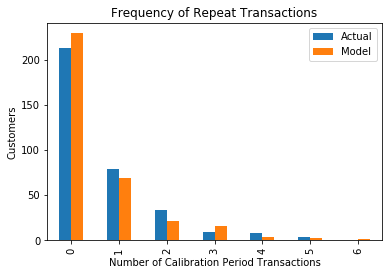

In [25]:
from lifetimes.plotting import plot_period_transactions
plot_period_transactions(bgf)

In [39]:
##Customer transactions predictions
###Based on customer history, we can now predict what an individual’s future purchases might look like:

t = 10
individual = data.loc['1761']
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

6.826856678705934

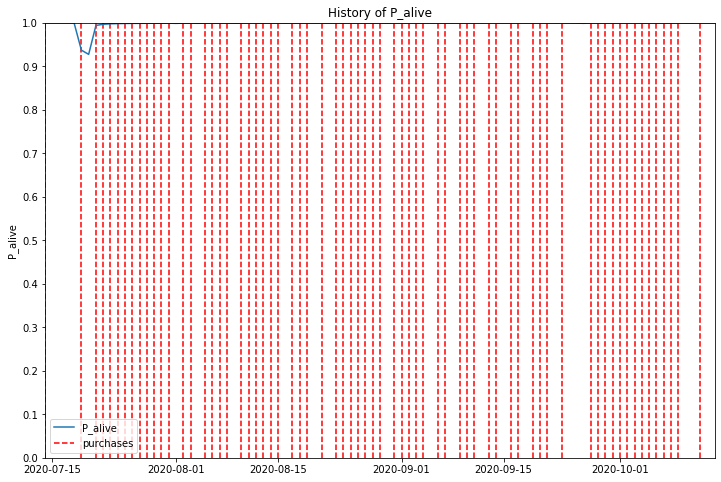

In [40]:
##Customer probability histories
###Given a customer transaction history, we can calculate their historical probability of being alive,
###according to our trained model. For example,
##we want to look at our best customer’s transactions history and see the probability of being alive:

from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = '1761'
days_since_birth = 92
sp_trans = df.loc[df['USER_OID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'TXN_DATE')

In [66]:
dff = df
dff

,USER_OID,TXN_DATE,PAID_AMOUNT,BILL_AMOUNT,OID
12,4,2020-05-12,1490,1490.0000,18
20,4,2020-05-12,1345,1345.0000,32
21,4,2020-05-13,62,62.1500,33
32,4,2020-05-13,685,685.0000,49
92,38,2020-05-20,50,505.0000,116
...,...,...,...,...,...
55498,3482,2020-10-14,262,262.0000,62519
55499,3482,2020-10-14,139,139.0000,62520
55500,3482,2020-10-14,328,328.0000,62521
55504,6485,2020-10-14,463,553.0000,62525


In [67]:

### FOR A NEW USER
print('ADD NEW CUSTOMER DATA:')

df1 = {'USER_OID': 8654, 'TXN_DATE':'2020-10-14 01:12:56' , 'PAID_AMOUNT': 128, 'BILL_AMOUNT': 189.0000 ,'OID':62527}
dff = dff.append(df1, ignore_index=True)

df1 = {'USER_OID': 8654, 'TXN_DATE':'2020-10-14 06:18:45' , 'PAID_AMOUNT': 225, 'BILL_AMOUNT': 289.0000 ,'OID':62528}
dff = dff.append(df1, ignore_index=True)

df1 = {'USER_OID': 8654, 'TXN_DATE':'2020-10-14 07:05:21' , 'PAID_AMOUNT': 1208, 'BILL_AMOUNT': 1289.0000 ,'OID':62529}
dff = dff.append(df1, ignore_index=True)

df1 = {'USER_OID': 8654, 'TXN_DATE':'2020-10-14 08:14:32' , 'PAID_AMOUNT': 1028, 'BILL_AMOUNT': 1089.0000 ,'OID':62530}
dff = dff.append(df1, ignore_index=True)

df1 = {'USER_OID': 8654, 'TXN_DATE':'2020-10-14 10:00:36' , 'PAID_AMOUNT': 1280, 'BILL_AMOUNT': 1289.0000 ,'OID':62531}
dff = dff.append(df1, ignore_index=True)

df1 = {'USER_OID': 8654, 'TXN_DATE':'2020-10-14 12:52:12' , 'PAID_AMOUNT': 1428, 'BILL_AMOUNT': 1689.0000 ,'OID':62532}
dff = dff.append(df1, ignore_index=True)

dff['TXN_DATE'] = pd.to_datetime(dff['TXN_DATE']).dt.date
dff['USER_OID'] = dff['USER_OID'].astype(str)
dff['PAID_AMOUNT'] = dff['PAID_AMOUNT'].astype(int)


print(dff)

ADD NEW CUSTOMER DATA:
      USER_OID    TXN_DATE  PAID_AMOUNT BILL_AMOUNT    OID
0            4  2020-05-12         1490   1490.0000     18
1            4  2020-05-12         1345   1345.0000     32
2            4  2020-05-13           62     62.1500     33
3            4  2020-05-13          685    685.0000     49
4           38  2020-05-20           50    505.0000    116
...        ...         ...          ...         ...    ...
24248     8654  2020-10-14          225         289  62528
24249     8654  2020-10-14         1208        1289  62529
24250     8654  2020-10-14         1028        1089  62530
24251     8654  2020-10-14         1280        1289  62531
24252     8654  2020-10-14         1428        1689  62532

[24253 rows x 5 columns]


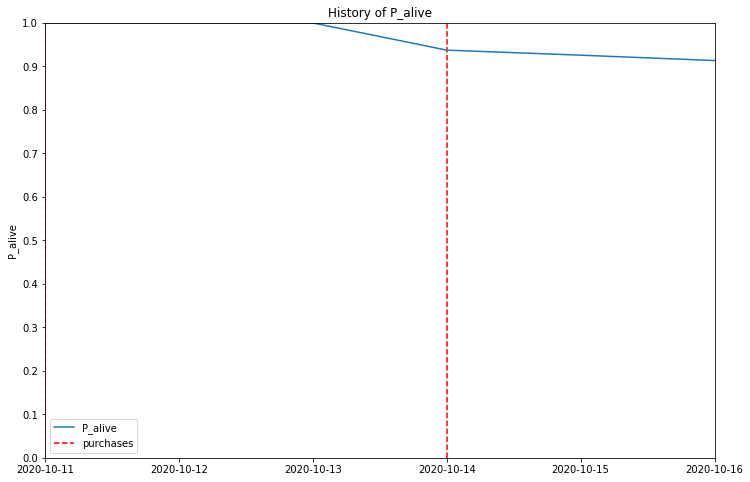

In [70]:
##Customer probability histories
###Given a customer transaction history, we can calculate their historical probability of being alive,
###according to our trained model. For example,
##we want to look at our best customer’s transactions history and see the probability of being alive:

from lifetimes.plotting import plot_history_alive
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(12,8))
id = '8654'
days_since_birth = 5
sp_trans = dff.loc[dff['USER_OID'] == id]
plot_history_alive(bgf, days_since_birth, sp_trans, 'TXN_DATE')

In [80]:
#def reTrain(dff):
dataa = utils.summary_data_from_transaction_data(
dff,
'USER_OID',
'TXN_DATE',
'PAID_AMOUNT'
)
bgf = BetaGeoFitter(penalizer_coef=0.01)
bgf.fit(dataa['frequency'], dataa['recency'], dataa['T']
)
summary_cal_holdout2 = utils.calibration_and_holdout_data(
dff,
'USER_OID',
'TXN_DATE',
calibration_period_end='2020-07-14',
observation_period_end='2020-07-15'
)
bgf.fit(summary_cal_holdout2['frequency_cal'], summary_cal_holdout2['recency_cal'], summary_cal_holdout2['T_cal'])

#    return dataa   


<lifetimes.BetaGeoFitter: fitted with 352 subjects, a: 0.01, alpha: 7.56, b: 0.10, r: 1.02>

In [81]:
##Customer transactions predictions
###Based on customer history, we can now predict what an individual’s future purchases might look like:
#reTrain(dff)
t = 10
individual = dataa.loc['8654']
bgf.predict(t, individual['frequency'], individual['recency'], individual['T'])

1.78232537539898

# MODIFIED BETAGEO FITTER

In [1]:
# penelizer_coeff = 0.001 to 0.1

In [82]:
### using ModifiedBetaGeoFilter 

from lifetimes import ModifiedBetaGeoFitter

mbgnbd = ModifiedBetaGeoFitter(penalizer_coef=0.01)
mbgnbd.fit(summary_cal_holdout['frequency_cal'], 
        summary_cal_holdout['recency_cal'], 
        summary_cal_holdout['T_cal'],
       verbose=True)
#bgf.fit(summary_cal_holdout['frequency_cal'], summary_cal_holdout['recency_cal'], summary_cal_holdout['T_cal'])
#plotting.plot_calibration_purchases_vs_holdout_purchases(bgf, summary_cal_holdout)

Optimization terminated successfully.
         Current function value: -0.797832
         Iterations: 42
         Function evaluations: 44
         Gradient evaluations: 44


C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in sqrt
  result = getattr(ufunc, method)(*inputs, **kwargs)


<lifetimes.ModifiedBetaGeoFitter: fitted with 352 subjects, a: 0.00, alpha: 7.90, b: 0.00, r: 1.02>

In [83]:
print(mbgnbd)

<lifetimes.ModifiedBetaGeoFitter: fitted with 352 subjects, a: 0.00, alpha: 7.90, b: 0.00, r: 1.02>


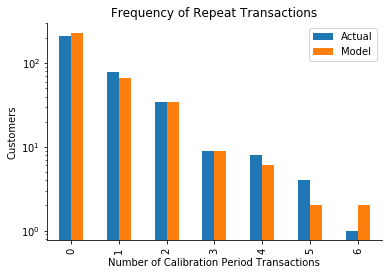

In [84]:
from lifetimes.plotting import plot_period_transactions
ax = plot_period_transactions(mbgnbd, max_frequency=7)
ax.set_yscale('log')
sns.despine();

Wall time: 366 ms


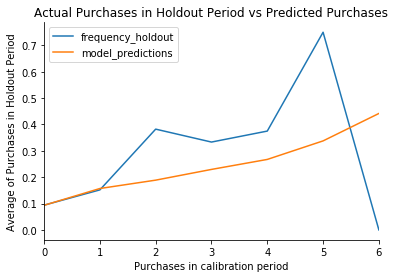

In [85]:
%%time 

from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases

plot_calibration_purchases_vs_holdout_purchases(mbgnbd, summary_cal_holdout)
sns.despine();

In [86]:
#elog['USER_OID'] = df['USER_OID'].values
elog = pd.DataFrame(df, columns = ['USER_OID', 'TXN_DATE']) 
elog.head()

,USER_OID,TXN_DATE
12,4,2020-05-12
20,4,2020-05-12
21,4,2020-05-13
32,4,2020-05-13
92,38,2020-05-20


In [87]:
elog = elog.reset_index(drop=True)

In [88]:
elog.head()

,USER_OID,TXN_DATE
0,4,2020-05-12
1,4,2020-05-12
2,4,2020-05-13
3,4,2020-05-13
4,38,2020-05-20


In [89]:
%%time
# Get expected and actual repeated cumulative transactions.

from lifetimes.utils import expected_cumulative_transactions

t = (elog['TXN_DATE'].max() - elog['TXN_DATE'].min()).days
data_set = expected_cumulative_transactions(mbgnbd, elog, 'TXN_DATE', 'USER_OID', t)

Wall time: 2.51 s


In [91]:
data_set.tail()

,actual,predicted
150,15157,18487.181598
151,15451,18863.642369
152,15708,19243.346255
153,15925,19626.422981
154,16140,20012.742821


Wall time: 5.66 s


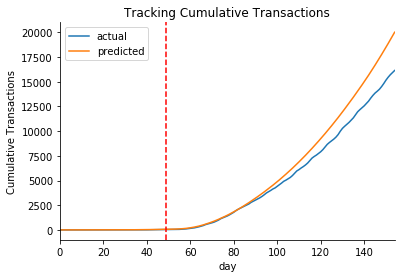

In [93]:
%%time
# Calibration period = 2020-05-12 to 2020-06-30
from datetime import datetime, time

cal = datetime.strptime('2020/06/30', '%Y/%m/%d').date()

from lifetimes.plotting import plot_cumulative_transactions
t = (elog['TXN_DATE'].max() - elog['TXN_DATE'].min()).days
t_cal = (cal - elog['TXN_DATE'].min()).days
plot_cumulative_transactions(mbgnbd, elog, 'TXN_DATE', 'USER_OID', t, t_cal, freq='D')
sns.despine()

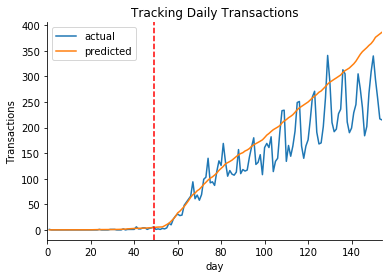

In [94]:

from lifetimes.plotting import plot_incremental_transactions
plot_incremental_transactions(mbgnbd, elog, 'TXN_DATE', 'USER_OID', t, t_cal, freq='D')
sns.despine()

In [ ]:
### STUFF BELOW THIS LINE IS FOR FURTHER IMPLEMENTAION

In [42]:
data_set.describe()

,actual,predicted
count,151.000000,151.000000
mean,3649.549669,3605.744093
std,4568.335732,4497.884258
min,0.000000,0.146881
25%,8.500000,20.496124
50%,1227.000000,1230.802847
75%,6495.000000,6442.160309
max,15154.000000,15030.048967


In [43]:
data.describe()

,frequency,recency,T,monetary_value,predicted_purchases
count,2849.000000,2849.000000,2849.000000,2849.000000,2849.000000
mean,5.320463,32.975781,49.992980,280.799255,0.093469
std,7.933148,32.215650,30.191418,396.619638,0.086857
min,0.000000,0.000000,0.000000,0.000000,0.004351
25%,0.000000,0.000000,23.000000,0.000000,0.035382
50%,2.000000,26.000000,50.000000,191.981818,0.064569
75%,7.000000,62.000000,78.000000,414.500000,0.122213
max,73.000000,124.000000,151.000000,7714.000000,0.696264


In [44]:
t = 184
print('Expected number of transactions for randomly choosen customer in the next {} days = {}'.format(t, bgf.expected_number_of_purchases_up_to_time(t)))

Expected number of transactions for randomly choosen customer in the next 184 days = 22.713422591480917


In [45]:
for i in range(1, 5):
    print('Probabilty of the making {} transactions in the next {} days is {}'.format(i, t, bgf.probability_of_n_purchases_up_to_time(t, i)))

Probabilty of the making 1 transactions in the next 184 days is 0.16682522477310435
Probabilty of the making 2 transactions in the next 184 days is 0.038389686877267015
Probabilty of the making 3 transactions in the next 184 days is 0.033524469375144396
Probabilty of the making 4 transactions in the next 184 days is 0.03023449582944889


In [46]:
returning_customers_summary = data[data['frequency']>0]
print('Number of customers = {}'.format(len(returning_customers_summary)))
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(returning_customers_summary['frequency'], returning_customers_summary['monetary_value'])

Number of customers = 1990


<lifetimes.GammaGammaFitter: fitted with 1990 subjects, p: 0.99, q: 3.39, v: 979.29>

In [47]:
data['CLTV'] = bgf.conditional_expected_number_of_purchases_up_to_time(365, data['frequency'], data['recency'], data['T']) * ggf.conditional_expected_average_profit(data['frequency'], data['monetary_value'])
data['CLTV']

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


USER_OID
10               NaN
1000    55517.372275
1001    16911.644766
1002             NaN
1003    17108.358527
            ...     
992      4750.301862
993              NaN
994     14246.382715
995      3673.496002
998      8215.228074
Name: CLTV, Length: 2849, dtype: float64

In [48]:
data['CLTV'].describe()

count      1990.000000
mean      17495.064365
std       22925.656289
min          93.364274
25%        6423.961274
50%       12027.042380
75%       21803.641009
max      697489.275643
Name: CLTV, dtype: float64

In [49]:
df

,USER_OID,TXN_DATE,PAID_AMOUNT,BILL_AMOUNT,OID
12,4,2020-05-12,1490,1490.0000,18
20,4,2020-05-12,1345,1345.0000,32
21,4,2020-05-13,62,62.1500,33
32,4,2020-05-13,685,685.0000,49
92,38,2020-05-20,50,505.0000,116
...,...,...,...,...,...
52309,3935,2020-10-10,208,278.0000,59080
52310,3935,2020-10-10,225,300.0000,59081
52311,6537,2020-10-10,2131,2131.0000,59082
52313,2757,2020-10-10,527,703.0000,59084


In [33]:
summary = data[data['frequency']>0]
print(summary.head())
print()
print('\nCustomers with atleast 1 repeat purchase\n', len(summary))

          frequency  recency     T  monetary_value  predicted_purchases
USER_OID                                                               
1000           41.0     80.0  85.0      312.756098             0.443891
1001            8.0     85.0  97.0      564.000000             0.083336
1003           11.0     81.0  91.0      365.636364             0.118250
1004            7.0     54.0  81.0      297.428571             0.084646
1006            4.0     11.0  32.0      222.500000             0.105415


Customers with atleast 1 repeat purchase
 2074


### The Gamma-Gamma model and the independence assumption


Gamma-Gamma model is based on the assumption that the number of transactions does not depend on their monetary value. The frequency and monetary value are not correlated if the output is close to zero. The Gamma-Gamma submodel, in fact, assumes that there is no relationship between the monetary value and the purchase frequency. In practice we need to check whether the Pearson correlation between the two vectors is close to 0 in order to use this model.

In [34]:
summary[['monetary_value', 'frequency']].corr()

,monetary_value,frequency
monetary_value,1.000000,-0.043425
frequency,-0.043425,1.000000


In [35]:
from lifetimes import GammaGammaFitter
ggf = GammaGammaFitter(penalizer_coef = 0)
ggf.fit(summary['frequency'],
        summary['monetary_value'])
print(ggf)

<lifetimes.GammaGammaFitter: fitted with 2074 subjects, p: 0.98, q: 3.34, v: 977.01>


In [36]:
print(ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).head(10))

USER_OID
1000    318.039349
1001    528.252333
1003    373.314304
1004    325.742336
1006    292.136183
1007    317.701712
1008    261.547178
1010    723.817515
1011    562.235426
1012    315.450645
dtype: float64


In [37]:
print("Expected conditional average profit: %s, Average profit: %s" % (
    ggf.conditional_expected_average_profit(
        summary['frequency'],
        summary['monetary_value']
    ).mean(),
    summary[summary['frequency']>0]['monetary_value'].mean()
))

Expected conditional average profit: 401.2952911616557, Average profit: 405.38540079254904


In [38]:
# refit the BG model to the summary_with_money_value dataset 
bgf.fit(summary['frequency'], summary['recency'], summary['T'])
print(ggf.customer_lifetime_value( 
    bgf, #the model to use to predict the number of future transactions 
    summary['frequency'], 
    summary['recency'], 
    summary['T'], 
    summary['monetary_value'], time=12, # months 
    discount_rate=0.01 # monthly discount rate ~ 12.7% annually 
).head(10)) 

USER_OID
1000    45164.694628
1001    15152.350539
1003    14836.984932
1004     9108.347883
1006     9146.391203
1007    13583.403577
1008    19721.238361
1010    36866.450878
1011    69411.694470
1012     6790.242028
Name: clv, dtype: float64
